# Example: Apply the spectral neural network model

This notebook demonstrates how to apply a previously trained spectral neural network model.  The demo uses the trained model shown in the manuscript. This model is defined in `src/spectral_neural_network.py` and the input data, trained model weights, and fitted normalizations should be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and saved to the `inputs` folder.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import xarray as xr
from matplotlib.gridspec import GridSpec

from src import das_xarray_helpers
from src import plots
from src import spectral_neural_network
from src import training_and_inference
from src import transforms
from src import waves

Input data, model weights, and fitted normalizations can be downloaded from Dryad (https://doi.org/10.5061/dryad.brv15dvnz) and should be saved to the `input_data` folder to resemble the following structure:

```
input_data/
├── model_states
│   ├── fk_convolutional_neural_network_hyperparameters.pth
│   ├── fk_convolutional_neural_network_model.pth
│   ├── fk_convolutional_neural_network_spectral_feature_norm.pth
│   ├── fk_convolutional_neural_network_target_norm.pth
│   ├── spectral_neural_network_hyperparameters.pth
│   ├── spectral_neural_network_model.pth
│   ├── spectral_neural_network_scalar_feature_norm.pth
│   ├── spectral_neural_network_spectral_feature_norm.pth
│   └── spectral_neural_network_target_norm.pth
├── oliktok_das_mooring_half-hourly_along_cable_dataset.nc
├── oliktok_das_mooring_hourly_along_cable_dataset.nc
├── oliktok_das_mooring_half-hourly_dataset.nc
└── oliktok_das_mooring_hourly_dataset.nc
```


In [2]:
HOURLY_DAS_MOORING_DATA_PATH = 'input_data/oliktok_das_mooring_hourly_dataset.nc'
HYPERPARAMETERS_PATH = 'input_data/model_states/spectral_neural_network_hyperparameters.pth'
MODEL_STATE_DICT_PATH = 'input_data/model_states/spectral_neural_network_model.pth'
SCALAR_FEATURE_NORM_STATE_DICT_PATH = 'input_data/model_states/spectral_neural_network_scalar_feature_norm.pth'
SPECTRAL_FEATURE_NORM_STATE_DICT_PATH = 'input_data/model_states/spectral_neural_network_spectral_feature_norm.pth'
TARGET_NORM_STATE_DICT_PATH = 'input_data/model_states/spectral_neural_network_target_norm.pth'

The spectral neural network uses hourly DAS data.

In [3]:
das_60min_ds = xr.open_dataset(HOURLY_DAS_MOORING_DATA_PATH)

Stack channel (ch) and time dimensions into a single dimension so that feature arrays can be fed sequentially to the model.

In [4]:
das_60min_stack_ds = das_xarray_helpers.stack_ch_and_time(das_60min_ds)
das_60min_stack_ds

<xarray.Dataset> Size: 24MB
Dimensions:                                    (frequency: 32, time_ch: 39345)
Coordinates:
    site                                       (time_ch) float64 315kB 1.0 .....
  * frequency                                  (frequency) float64 256B 0.007...
  * time_ch                                    (time_ch) object 315kB MultiIndex
  * time                                       (time_ch) datetime64[ns] 315kB ...
  * ch                                         (time_ch) int32 157kB 1088 ......
Data variables:
    strain_spectral_density                    (time_ch, frequency) float64 10MB ...
    strain_spectral_density_variance           (time_ch) float64 315kB 4.451e...
    cosine_squared_wave_direction              (time_ch) float64 315kB 0.5468...
    dist                                       (time_ch) float64 315kB 8.791 ...
    burial_depth                               (time_ch) float64 315kB 2.0 .....
    depth                                      (time_ch) float64 315kB -5.274...
    target_seafloor_pressure_spectral_density  (time_ch, frequency) float64 10MB ...
    target_seafloor_pressure_variance          (time_ch) float64 315kB 0.0243...
    target_significant_wave_height             (time_ch) float64 315kB 0.8401...
    target_energy_period                       (time_ch) float64 315kB 6.944 ...
    is_train                                   (time_ch) bool 39kB True ... F...
    is_test                                    (time_ch) bool 39kB False ... ...
Attributes:
    history:        2025-10-17T10:41. Created.
    title:          DAS and seafloor mooring data to accompany the article "N...
    summary:        Hourly DAS features and target mooring variables for all ...
    id:             https://doi.org/10.5061/dryad.brv15dvnz
    license:        CC0
    date_created:   2025-10-17T10:41
    creator_name:   Jacob Davis (UW-APL, WHOI)
    creator_email:  jacob.davis@whoi.edu
    institution:    University of Washington Applied Physics Laboratory (UW-A...
    references:     
    comment:        See accompanying publication in "references" attribute
    _FillValue:     nan

Apply data transformations and convert DataArrays to a feature tensor. Scalar features, spectral features, and target tensors are treated separately (the target transform will be used later).  Scalar (depth, cosine squared wave direction) and spectral (strain rate spectral density) features are concatenated along the second dimension. The first two elements are depth and cosine squared wave direction, and the remaining 32 entries are strain rate spectral densities in order of increasing frequency (note features are already transformed).

In [5]:
# Strain spectra (features) and pressure spectra (targets) are
# log-transformed to compress their dynamic range. Scalar features
# (depth, direction) are left untransformed.
scalar_feature_transform = None
spectral_feature_transform = transforms.LogTransform()
target_transform = transforms.LogTransform()

# Convert training and test datasets to tensors. Note that data are
# transformed inside this function.
feature_tensor = spectral_neural_network.feature_tensor_from_dataset(
    das_ds=das_60min_stack_ds,
    scalar_feature_transform=scalar_feature_transform,
    spectral_feature_transform=spectral_feature_transform,
)

# [depth, cosine_squared_wave_direction, S[1], ..., S[32]]
feature_tensor

tensor([[ -5.2739,   0.5468,  12.4540,  ...,  10.2427,  10.4248,  10.3070],
        [ -5.2872,   0.5468,  12.5280,  ...,  10.3616,  10.4704,  10.4765],
        [ -5.3006,   0.5468,  12.5937,  ...,  10.5257,  10.8920,  10.6629],
        ...,
        [-18.1643,   0.9036,  10.4730,  ...,  10.2059,  10.1066,  10.1402],
        [-18.1673,   0.9036,  10.5737,  ...,  10.4285,  10.7714,  10.3947],
        [-18.1704,   0.9036,   9.5050,  ...,   9.6794,  10.2097,   9.7869]])

Load the trained model's hyperparameters and state dictionary and reconstruct the neural network.

In [6]:
hyperparameters = torch.load(HYPERPARAMETERS_PATH)

model = spectral_neural_network.SpectralNeuralNetwork(
   dim_in=hyperparameters['dim_in'],
   n_hidden_layers_1=hyperparameters['n_hidden_layers_1'],
   n_hidden_layers_2=hyperparameters['n_hidden_layers_2'],
   p_dropout=hyperparameters['p_dropout'],
   dim_out=hyperparameters['dim_out'],
)
model.load_state_dict(
   state_dict=torch.load(MODEL_STATE_DICT_PATH),
)
model

SpectralNeuralNetwork(
  (model): Sequential(
    (0): Linear(in_features=34, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2765441648207274, inplace=False)
    (3): Linear(in_features=16, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2765441648207274, inplace=False)
    (6): Linear(in_features=128, out_features=32, bias=True)
  )
)

Define feature and target min-max normalizations and load their state dicts.


In [7]:
# Initialize normalization transforms and load their state dicts.
scalar_feature_norm = transforms.MinMaxNormalization()
spectral_feature_norm = transforms.MinMaxNormalization()
target_norm = transforms.MinMaxNormalization()

scalar_feature_norm.load_state_dict(
    torch.load(SCALAR_FEATURE_NORM_STATE_DICT_PATH)
)
spectral_feature_norm.load_state_dict(
    torch.load(SPECTRAL_FEATURE_NORM_STATE_DICT_PATH)
)
target_norm.load_state_dict(
    torch.load(TARGET_NORM_STATE_DICT_PATH)
)

<All keys matched successfully>

Apply normalizations to the feature tensor. Here, `start_spec` accounts for the offset of spectral features in the feature tensor.  NOTE: it is important that the feature tensor is not normalized more than once.

In [8]:
start_spec = 2  # number of scalar features at start of feature vector

# Clone the feature tensor so it is not normalized in place.
feature_tensor_norm = feature_tensor.clone()
feature_tensor_norm[..., 0:start_spec] = scalar_feature_norm.transform(feature_tensor[..., 0:start_spec])
feature_tensor_norm[..., start_spec:] = spectral_feature_norm.transform(feature_tensor[..., start_spec:])

feature_tensor_norm

tensor([[1.0000e+00, 5.3333e-01, 7.7903e-01,  ..., 2.9837e-01, 3.8538e-01,
         3.2107e-01],
        [9.9897e-01, 5.3333e-01, 7.9619e-01,  ..., 3.3637e-01, 4.0006e-01,
         3.8505e-01],
        [9.9793e-01, 5.3333e-01, 8.1145e-01,  ..., 3.8877e-01, 5.3561e-01,
         4.5541e-01],
        ...,
        [1.4642e-03, 9.0105e-01, 3.1951e-01,  ..., 2.8662e-01, 2.8309e-01,
         2.5812e-01],
        [1.2291e-03, 9.0105e-01, 3.4288e-01,  ..., 3.5771e-01, 4.9683e-01,
         3.5416e-01],
        [9.9125e-04, 9.0105e-01, 9.4982e-02,  ..., 1.1850e-01, 3.1623e-01,
         1.2476e-01]])

Apply the model to the transformed and normalized feature tensor.  Order is important when inverse transforming the model output: first inverse the target normalization, then inverse the target log-transformation (predictions and targets share the same transformations).

In [9]:
# Apply the model.
prediction_tensor = training_and_inference.apply_regression_model(model, feature_tensor_norm)

# And reverse the transformations to get back to original pressure units.
prediction_tensor_no_transform = target_transform.inverse_transform(
    target_norm.inverse_transform(prediction_tensor)
)

prediction_tensor_no_transform

tensor([[4.7025e-03, 6.0324e-03, 4.5493e-03,  ..., 3.0651e-05, 2.1129e-05,
         1.7418e-05],
        [4.0450e-03, 5.3780e-03, 3.8255e-03,  ..., 2.9961e-05, 2.0826e-05,
         1.7424e-05],
        [4.6287e-03, 6.1429e-03, 4.8953e-03,  ..., 4.7504e-05, 3.1290e-05,
         2.5901e-05],
        ...,
        [3.9012e-04, 3.0094e-04, 3.2193e-04,  ..., 3.2273e-06, 3.0812e-06,
         2.8227e-06],
        [9.2116e-04, 7.1570e-04, 6.4438e-04,  ..., 4.2158e-06, 4.0726e-06,
         3.8261e-06],
        [3.3858e-04, 2.5925e-04, 2.9625e-04,  ..., 2.9877e-06, 2.8737e-06,
         2.6441e-06]])

Assign the predictions to a DataArray, unstack the channel and time dimensions, and assign to the original Xarray Dataset.

In [10]:
prediction_stack_da = xr.DataArray(
    data=prediction_tensor_no_transform.detach().numpy(),
    dims=['time_ch', 'frequency'],
    coords={
        'time_ch': das_60min_stack_ds['time_ch'],
        'frequency': das_60min_stack_ds['frequency']
    }
)

prediction_da = das_xarray_helpers.unstack_ch_and_time(prediction_stack_da)

das_60min_ds['seafloor_pressure_spectral_density'] = prediction_da

Compare target and prediction spectra at a random channel and time index.

Text(0.5, 1.0, 'Example test prediction\nch=2420, time=2023-09-18 01:00')

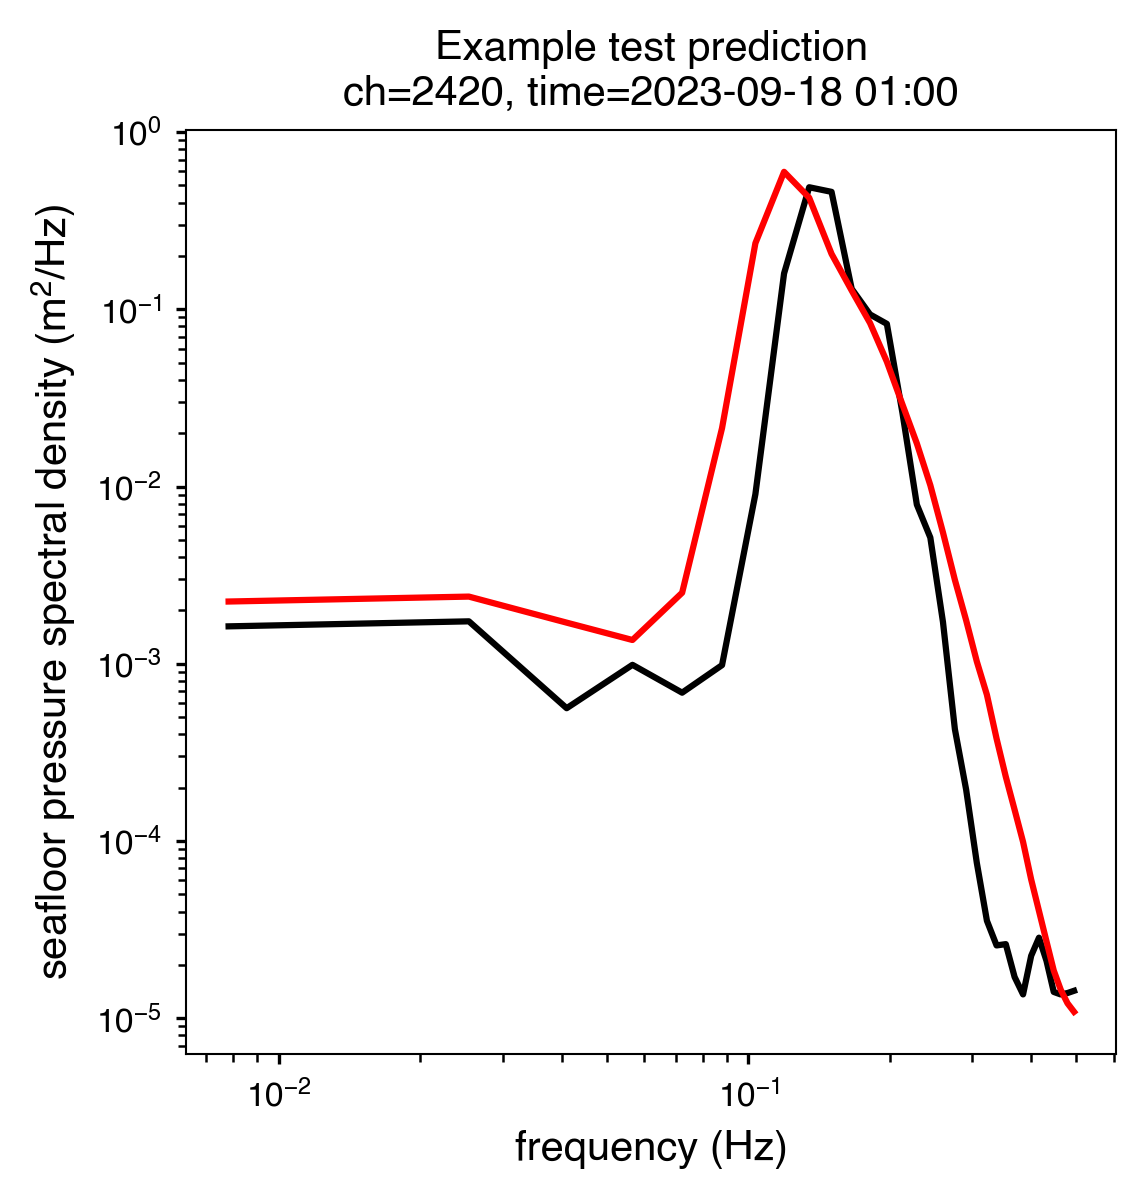

In [11]:
ch = np.random.choice(das_60min_ds['ch'].size)
time = np.random.choice(das_60min_ds['time'].size)

if das_60min_ds.isel(ch=ch, time=time)['is_train']:
    title_label = 'training'
    prediction_color = 'b'
else:
    title_label = 'test'
    prediction_color = 'r'

fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.loglog(
    das_60min_ds['frequency'],
    das_60min_ds.isel(ch=ch, time=time)['target_seafloor_pressure_spectral_density'],
    color='k',
    label='target',
)
ax.loglog(
    das_60min_ds['frequency'],
    das_60min_ds.isel(ch=ch, time=time)['seafloor_pressure_spectral_density'],
    color=prediction_color,
    label='prediction',
)
ax.set_xlabel('frequency (Hz)')
ax.set_ylabel('seafloor pressure spectral density (m$^2$/Hz)')
ax.set_title(
    f'Example {title_label} prediction\n'
    f'ch={das_60min_ds.ch[ch].item()}, '
    f'time={das_60min_ds.time[time].dt.strftime("%Y-%m-%d %H:%M").item()}'
)

Transform seafloor pressure spectral densities to surface elevation spectral densities and compute bulk variables.

In [ ]:
# Attenuation cutoff is set to remove erroneous tail shape.
ATTENUATION_CUTOFF = 25

das_60min_ds['seafloor_pressure_variance'] = waves.spectral_var(
    das_60min_ds['seafloor_pressure_spectral_density']
)

das_60min_ds['energy_period'] = waves.energy_period(
    das_60min_ds['seafloor_pressure_spectral_density'],
)

attenuation_tf = waves.pressure_spectra_to_surface_spectra(
    depth=das_60min_ds['depth'],
    frequency=das_60min_ds['frequency'],
)

das_60min_ds['pressure_to_surface_transfer_function'] = attenuation_tf.where(
    attenuation_tf < ATTENUATION_CUTOFF,
    np.nan
)

das_60min_ds['surface_elevation_spectral_density'] = \
    das_60min_ds['seafloor_pressure_spectral_density'] * das_60min_ds['pressure_to_surface_transfer_function']

das_60min_ds['significant_wave_height'] = waves.significant_wave_height(
    das_60min_ds['surface_elevation_spectral_density'].fillna(0)  # Could handle NaNs better here.
)


Reindex the dataset by site.

In [14]:
das_60min_ds = das_xarray_helpers.index_by_site(das_60min_ds)

Separate training and test datasets for plotting.

In [15]:
das_60min_train_ds = das_xarray_helpers.get_train(das_60min_ds)
das_60min_test_ds = das_xarray_helpers.get_test(das_60min_ds)

Plot the training, test, and target significant wave heights over the entire analysis period.

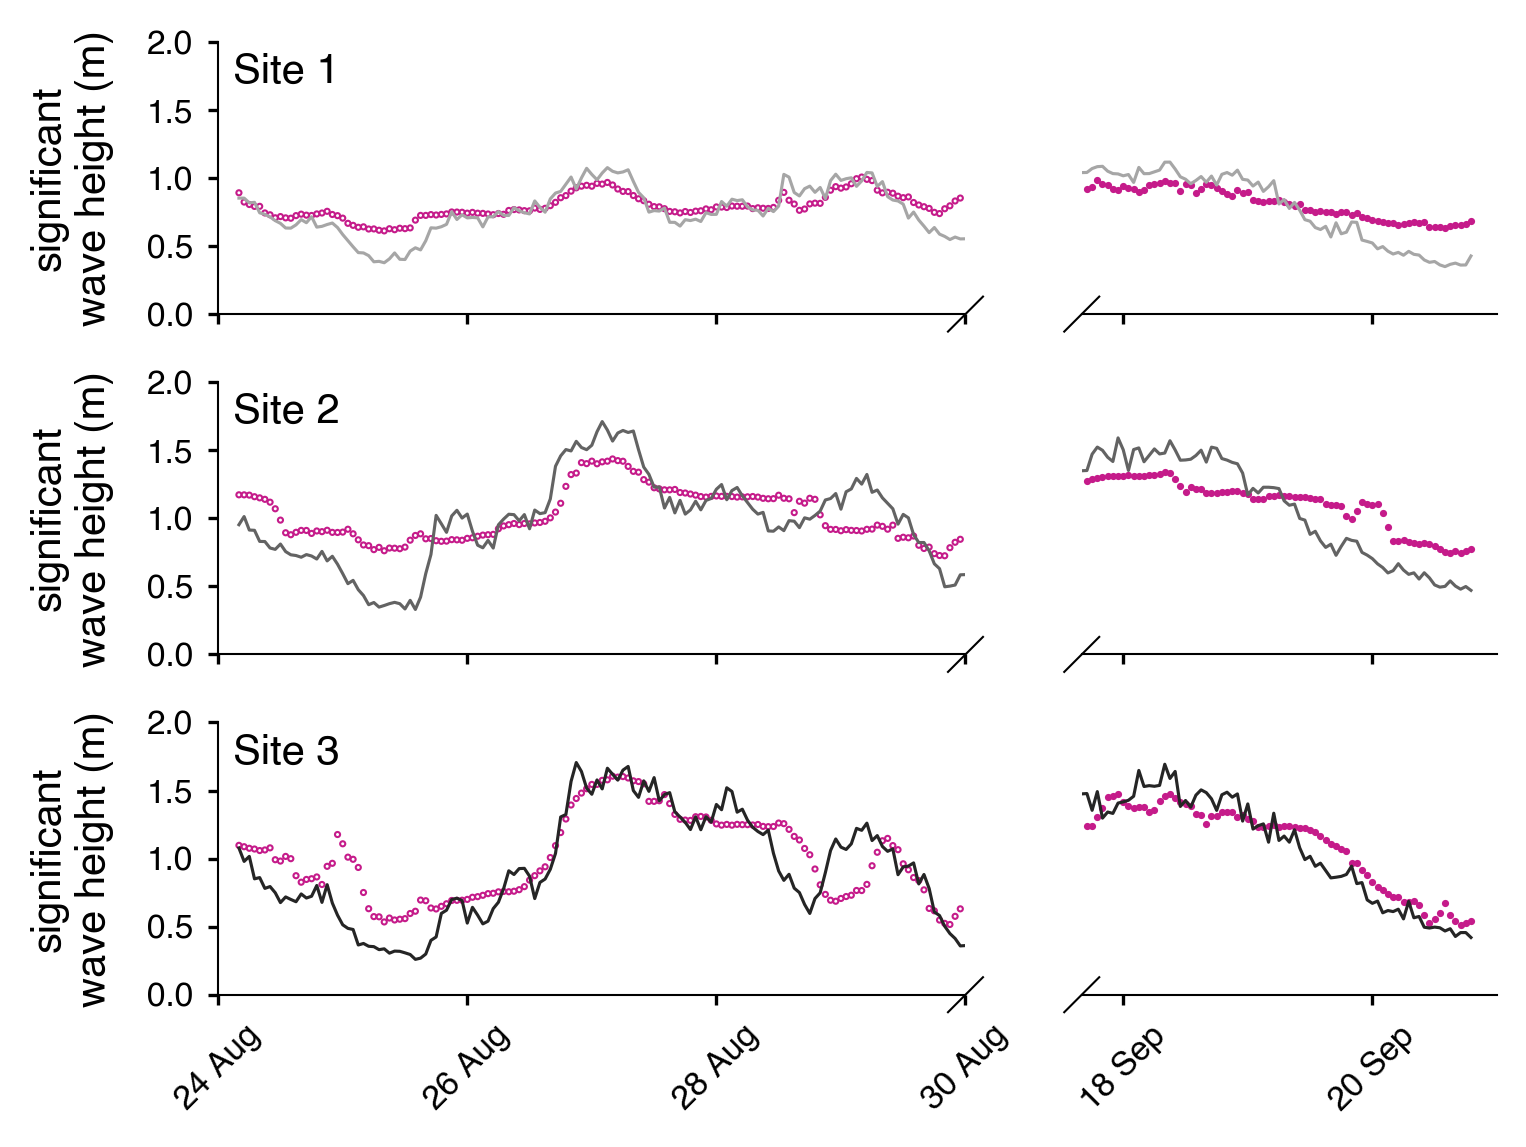

In [ ]:
sites = [1, 2, 3]
start_time = pd.Timestamp('2023-08-24')
end_time = pd.Timestamp('2023-09-21')

# Create a three-panel time series using the brokenaxes package.
fig = plt.figure(figsize=(plots.figure_full_width, plots.figure_full_width*3/4))
gridspec = GridSpec(3, 1, hspace=0.25, wspace=0.1)
ax_1 = plots.create_time_series_axes(start_time, end_time, gridspec[0])
ax_2 = plots.create_time_series_axes(start_time, end_time, gridspec[1])
ax_3 = plots.create_time_series_axes(start_time, end_time, gridspec[2])
axes = [ax_1, ax_2, ax_3]

for ax, site in zip(axes, sites):
    ax.scatter(
        das_60min_train_ds.sel(site=site)['time'],
        das_60min_train_ds.sel(site=site)['significant_wave_height'].mean(dim='ch'),
        label=f'Site {site}',
        color=plots.spectral_nn_color,
        **plots.train_scatter_kwargs,
    )
    ax.scatter(
        das_60min_test_ds.sel(site=site)['time'],
        das_60min_test_ds.sel(site=site)['significant_wave_height'].mean(dim='ch'),
        label=f'Site {site}',
        color=plots.spectral_nn_color,
        **plots.test_scatter_kwargs,
    )
    ax.plot(
        das_60min_ds.sel(site=site)['time'],
        das_60min_ds.sel(site=site)['target_significant_wave_height'].mean(dim='ch'),
        label=f'Site {site}',
        color=plots.mooring_site_colors[site],
        **plots.mooring_plot_kwargs,
    )
    ax.axs[0].annotate(f'Site {site}', xy=(0.02, 0.85), xycoords='axes fraction')
    ax.set_ylim([0, 2])
    ax.set_ylabel('significant\nwave height (m)', labelpad=25)
    plots.configure_time_series_xaxis(
        start_time, end_time, ax,
        labels=True if ax==axes[-1] else False
    )
